* This notebook was made to look at the plume position defined by $x = \frac{\iint xf(x,y)dxdy}{\iint f(x,y)dxdy}$, $y = \frac{\iint yf(x,y)dxdy}{\iint f(x,y)dxdy}$, $f(x,y) = \int \frac{S_{0}-S}{S_{0}}dz$, affected by winds and the Coriolis force. $S_{0}$ = 30.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

In [33]:
octriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
mayriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_U.nc')
janriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_U.nc')

octnowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
maynowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_U.nc')
jannowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_U.nc')

octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [34]:
octriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
mayriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_V.nc')
janriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_V.nc')

octnowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
maynowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_V.nc')
jannowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_V.nc')

octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [4]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted+1,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted+1,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [5]:
def threshold_whole_domain2(grid_T,tst,ted,dep_ind,dep):
    """Plot the boundary of the plume and threshold salinity"""
    
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    ## plot plume edge on 
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(1,))
    print(S_thre)
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])

In [6]:
def area_plume(grid_T,tst,ted,dep_ind,dep,yslices,xslices):
    """Return the indices of plume region based on definition"""
    jss  = []; iss = []; 
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for j in np.arange(yslices):
        for i in np.arange(xslices):
            if W[j,i] - S_thre >= 0.:
                jss.append(j)
                iss.append(i)
    return jss, iss, S_thre,W

In [7]:
def test_boundary(jss,iss,grid_T):
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])  
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    for j, i in zip(jss,iss):
        ax.plot(lon[j,i],lat[j,i],'*')
    return ax

In [8]:
def freshwater_xy(grid_T,tst,ted,dep_ind,xslices):
    """Calculate the freshwater over depths for all grid cells"""
    S0 = 30;
    S = grid_T.variables['vosaline'][tst:ted+1,:,:,:xslices]
    ssh = grid_T.variables['sossheig'][...,:xslices]
    fresh = np.zeros(S.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[...,:xslices]*tmask[...,:xslices],axis = 0)
            fresh[t,z] = (1-S[t,z]/S0)*e3t[z,:,:xslices]*adj_ssh[:]*tmask[z,:,:xslices] ## mask zero salinity here
    fresh_depth = np.nansum(fresh,axis = 1) ## integral over depths
    fresh_ave = np.nanmean(fresh_depth,axis=0) ## averaged over time of fresh water at each grid cell
    return fresh_ave

In [14]:
def plume_position1(grid_T,tst,ted,dep,fresh_ave,yslices,xslices):
    """Identify centered plume position defined by the formula shown in the first markdown"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for jj in np.arange(yslices):
        for ii in np.arange(xslices):
            if W[jj,ii] - S_thre >= 0.:
                j_po_nu[jj,ii] = np.nan
                j_po_de[jj,ii] = np.nan
                i_po_nu[jj,ii] = np.nan
                i_po_de[jj,ii] = np.nan
            elif  W[jj,ii] - S_thre < 0:
                j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

In [10]:
def plume_position2(jss,iss,fresh_ave,yslices,xslices):
    """This is the wrong metric, don't use this!!!"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    for j,i in zip(jss,iss):
        for jj in np.arange(yslices):
            for ii in np.arange(xslices):
                if jj ==j and ii == i:
                    j_po_nu[jj,ii] = np.nan
                    j_po_de[jj,ii] = np.nan
                    i_po_nu[jj,ii] = np.nan
                    i_po_de[jj,ii] = np.nan
                else:
                    j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

#  Test Method1

In [11]:
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
jss,iss,S_thre,W = area_plume(maynowind_T,360,455,10,0,yslices,xslices)

In [12]:
lon = mayall_T.variables['nav_lon']
lat = mayall_T.variables['nav_lat']

In [13]:
fresh_ave = freshwater_xy(maynowind_T,360,455,10,xslices)

In [14]:
j_po,i_po,j_oa,j_de = plume_position1(maynowind_T,360,455,0,fresh_ave,yslices,xslices)
print(j_po,i_po)

88.3532721614 56.6865447369


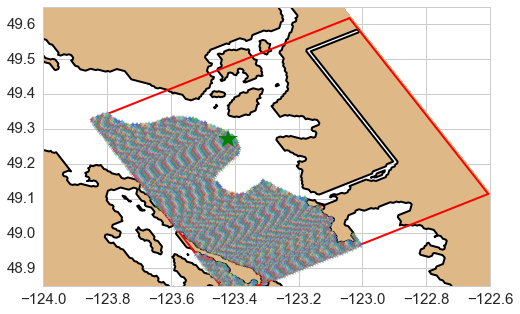

In [15]:
ax = test_boundary(jss,iss,maynowind_T)
ax.plot(lon[j_po,i_po],lat[j_po,i_po],'g*',markersize = 20)

(48.85, 49.65)

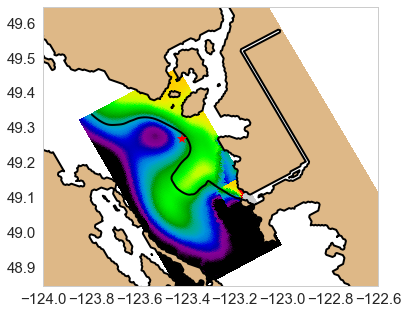

In [16]:
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fresh_ave,cmap = 'spectral',vmin = 2, vmax = 5)
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ##
ax.plot(lon[j_po,i_po],lat[j_po,i_po],'r*',markersize = 10)
ax.set_xlim([-124.,-122.6])
ax.set_ylim([48.85,49.65])

In [11]:
def plot_plume_position(grid_T1,grid_T2,tst,ted,dep_ind,dep,yslices,xslices,strings):
    """Plot the plume position under with and without Coriolis force, or with or without moderate/strong wind,
    here by convention, grid_T1 should always be all_T.nc. Pcolormesh of last plot is the difference."""
    fresh_aves = {}; ipos = {};jpos = {}
    #jss,iss,S_thre,W = area_plume(grid_T1,tst,ted,dep_ind,dep,yslices,xslices) ## plume boundary same with f and no f
    fig,axs = plt.subplots(1,3,figsize = (20,9))
    for gridT, string, ax,c in zip([grid_T1,grid_T2],strings,[axs[0],axs[1]],['g','purple']):
        jss,iss,S_thre,W = area_plume(gridT,tst,ted,dep_ind,dep,yslices,xslices) ## plume boundary different
        fresh_aves[string] = freshwater_xy(gridT,tst,ted,dep_ind,xslices)
        jpos[string],ipos[string] = plume_position1(gridT,tst,ted,dep,fresh_aves[string],yslices,xslices)
    
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        
        fr_aveno0 = np.ma.masked_values(fresh_aves[string],0)
        CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'jet')
        cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
        cbar.set_label('Freshwater at each grid cell [m]')
        ax.plot(lon[jpos[string],ipos[string]],lat[jpos[string],ipos[string]],color =c,marker = '*',markersize = 10,label =string)
        ax.legend(loc = 'best')
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
        plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
        ax.plot(lon[0:,xslices],lat[0:,xslices],'r-')
    ax = axs[2]
    fr_aveno0 = np.ma.masked_values(fresh_aves[strings[1]]-fresh_aves[strings[0]],0)
    CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = -2, vmax = 2,cmap = 'bwr')
    cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
    cbar.set_label('Difference of freshwater at each grid cell [m]')
    ax.plot(lon[jpos[strings[0]],ipos[strings[0]]],lat[jpos[strings[0]],ipos[strings[0]]],color = 'g',marker = '*',markersize = 10,label =strings[0])
    ax.plot(lon[jpos[strings[1]],ipos[strings[1]]],lat[jpos[strings[1]],ipos[strings[1]]],color = 'purple',marker = '*',markersize = 10,label =strings[1])
    #CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
    #plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)  
    ax.legend(loc = 'best')
    for ax in axs:    
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.6])
        ax.set_ylim([48.85,49.65])
    return jpos,ipos

In [31]:
def quiver_salinity(grid_T1,grid_T2,grid_U1,grid_U2,grid_V1,grid_V2,t1,t2,colormap,st,dep,cmin = -6,cmax = 6,ave = False):
    """Quiver velocity on top of surface salinity"""
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    cm = plt.cm.get_cmap(colormap,12)
    theta = np.pi*29/180
    S = {};U = {};V= {}
    for gridT, gridU,gridV,run, ax in zip([grid_T1,grid_T2],[grid_U1,grid_U2],[grid_V1,grid_V2],['all','nowind'],[axs[0],axs[1]]):
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        if ave ==False:
            S[run] =gridT.variables['vosaline'][t1,0]
            S[run] = np.ma.masked_values(S[run],0)
            u = gridU.variables['vozocrtx'][t1,0]
            v = gridV.variables['vomecrty'][t1,0]
            U[run],V[run] = viz_tools.unstagger(u,v)
            #rotate       
            U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
            V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
        else:
            S[run] =np.ma.masked_values(np.nanmean(gridT.variables['vosaline'][t1:t2+1,0],axis = 0),0)
            u = gridU.variables['vozocrtx'][t1:t2+1,0]
            v = gridV.variables['vomecrty'][t1:t2+1,0]
            U[run],V[run] = viz_tools.unstagger(u,v)
            #rotate       
            U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
            V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
            U[run] = np.nanmean(U[run],axis = 0)
            V[run] = np.nanmean(V[run],axis = 0)
            
        mesh=ax.pcolormesh(lon,lat,S[run],vmin =0,vmax = 33,cmap=cm) 
        cbar = fig.colorbar(mesh,ax = ax)
        cbar.set_label('Practical Salinity')
        quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U[run][::st, ::st], V[run][::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ## add minimum salinity plot if available
    sal_diff = S['nowind'] - S['all']
    U_diff = U['nowind'] - U['all']
    V_diff = V['nowind'] - V['all']
    ax = axs[2]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    cbar = fig.colorbar(mesh,ax = ax)
    cbar.set_label('Difference of Practical Salinity')
    quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=12,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])

In [12]:
j0 = 82;i0 = 50;j1 = 70;i1 = 44
print(geo_tools.haversine(X[380+j0,240+i0],Y[380+j0,240+i0],X[380+j1,240+i1],Y[380+j1,240+i1]))
print(X[380+j0,240+i0],Y[380+j0,240+i0])
print(X[380+j1,240+i1],Y[380+j1,240+i1])

6.51901447286
-123.431671143 49.2352752686
-123.422561646 49.1769142151


# Wind effects

{'all': 87.551362299626035, 'nowind': 70.456811624486193} {'all': 59.178554124398964, 'nowind': 46.61133038481271}


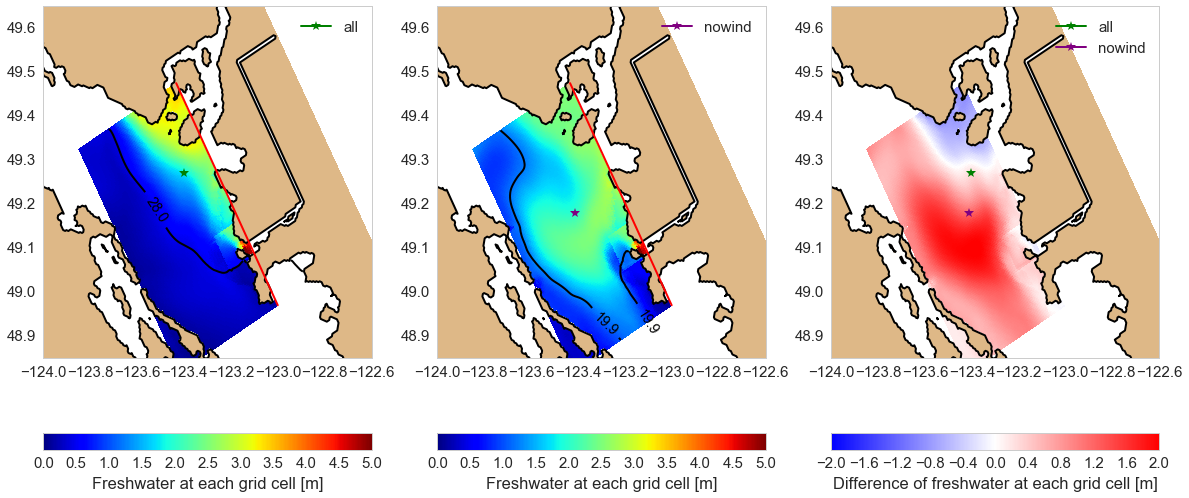

In [11]:
## wind from south blow to north oct high
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
jpos_oct_wind,ipos_oct_wind = plot_plume_position(octall_T,octnowind_T,480,551,10,0,yslices,xslices,['all','nowind'])
print(jpos_oct_wind,ipos_oct_wind)

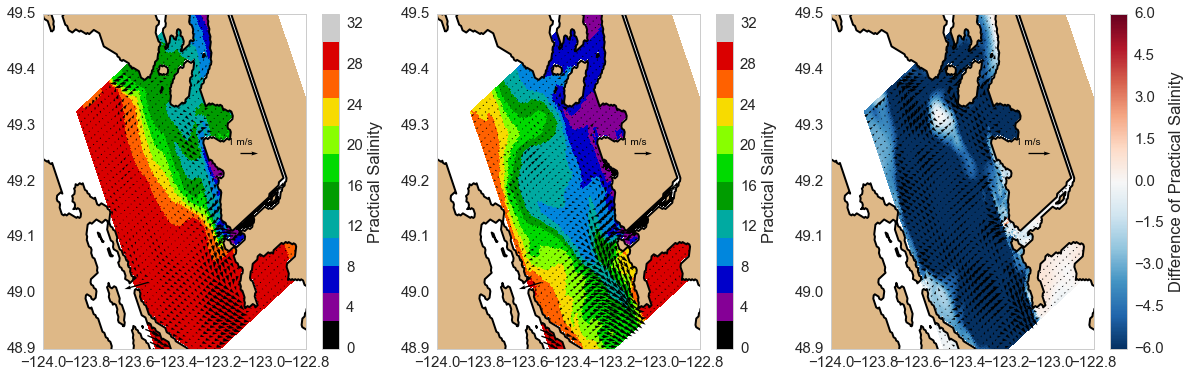

In [35]:
quiver_salinity(octall_T,octnowind_T,octall_U,octnowind_U,octall_V,octnowind_V,480,551,'spectral',3,0,ave = False)

{'all': 91.630228127267046, 'nowind': 70.276832774448394} {'all': 56.429887579296384, 'nowind': 48.382658675119316}


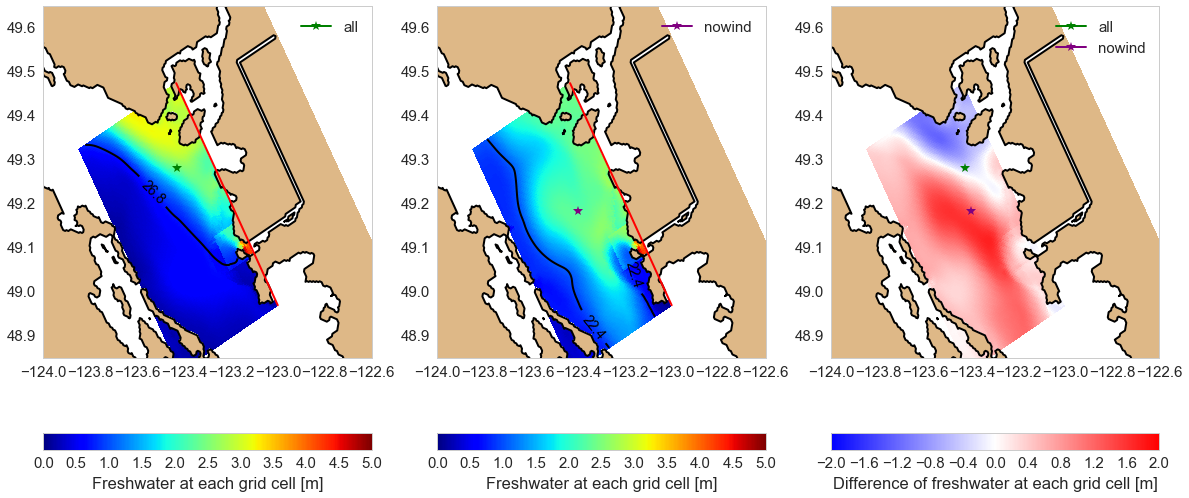

In [12]:
## wind from south blow to north oct moderate
jpos_oct_windMo,ipos_oct_windMo = plot_plume_position(octall_T,octnowind_T,408,480,10,0,yslices,xslices,['all','nowind'])
print(jpos_oct_windMo,ipos_oct_windMo)

{'all': 84.84540214891463, 'nowind': 84.522752703630843} {'all': 53.416947085737846, 'nowind': 64.469895744241143}


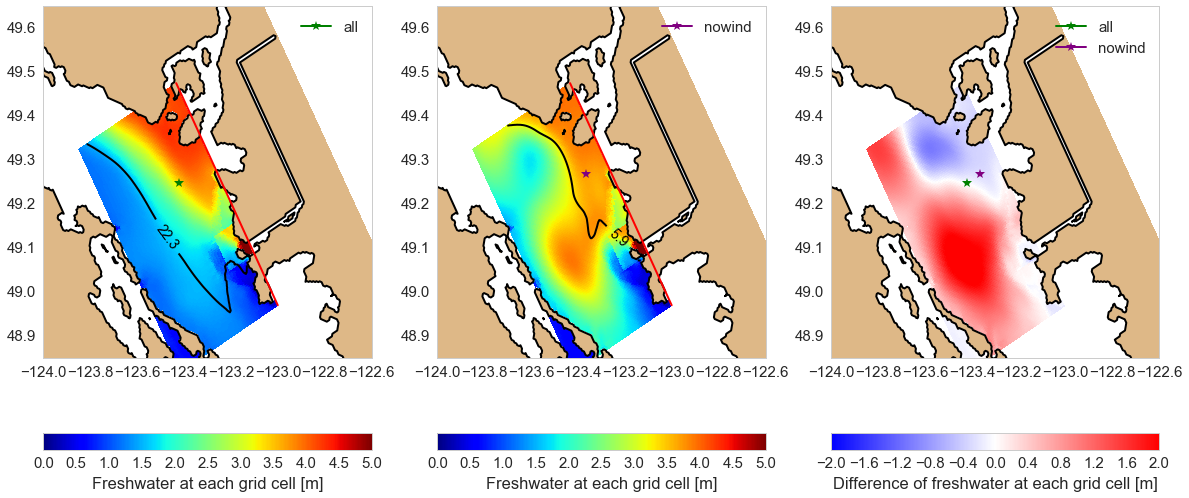

In [13]:
## wind from south blow to north, moderate may
jpos_may_windNW,ipos_may_windNW = plot_plume_position(mayall_T,maynowind_T,288,359,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windNW,ipos_may_windNW)

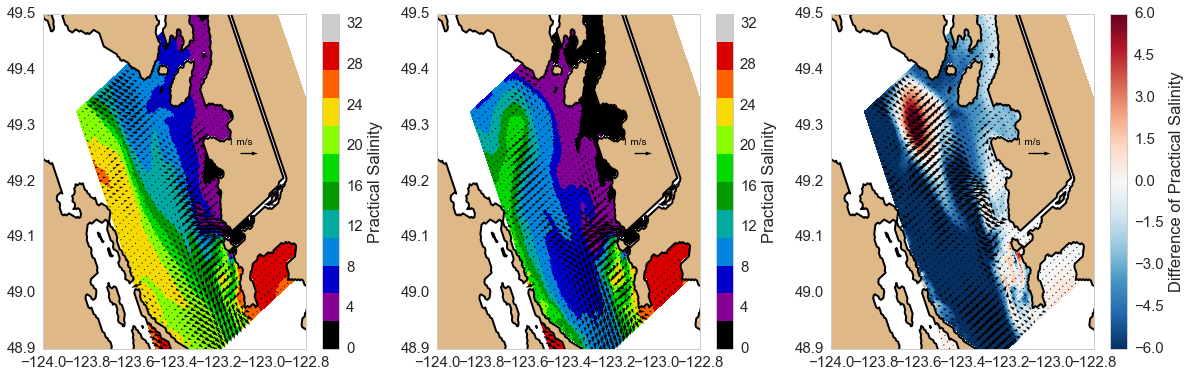

In [36]:
quiver_salinity(mayall_T,maynowind_T,mayall_U,maynowind_U,mayall_V,maynowind_V,288,359,'spectral',3,0,ave = False)

{'all': 84.543465596927291, 'nowind': 88.353272161370185} {'all': 50.564416146907654, 'nowind': 56.68654473694199}


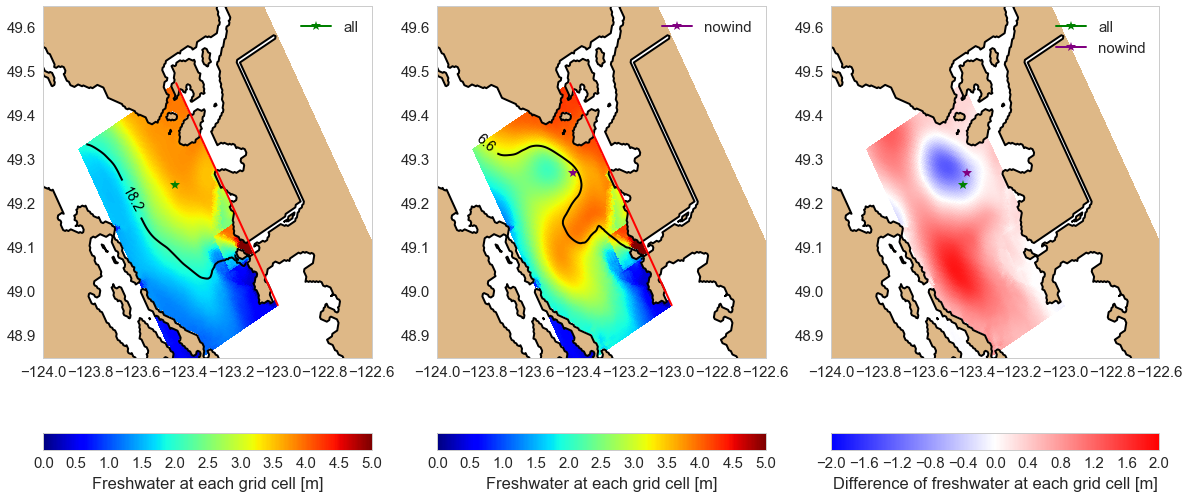

In [14]:
## wind from north blow to south, moderate may 
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,360,455,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE)

{'all': 85.41068475006098, 'nowind': 89.292772154062206} {'all': 53.200467594674386, 'nowind': 62.308577305202824}


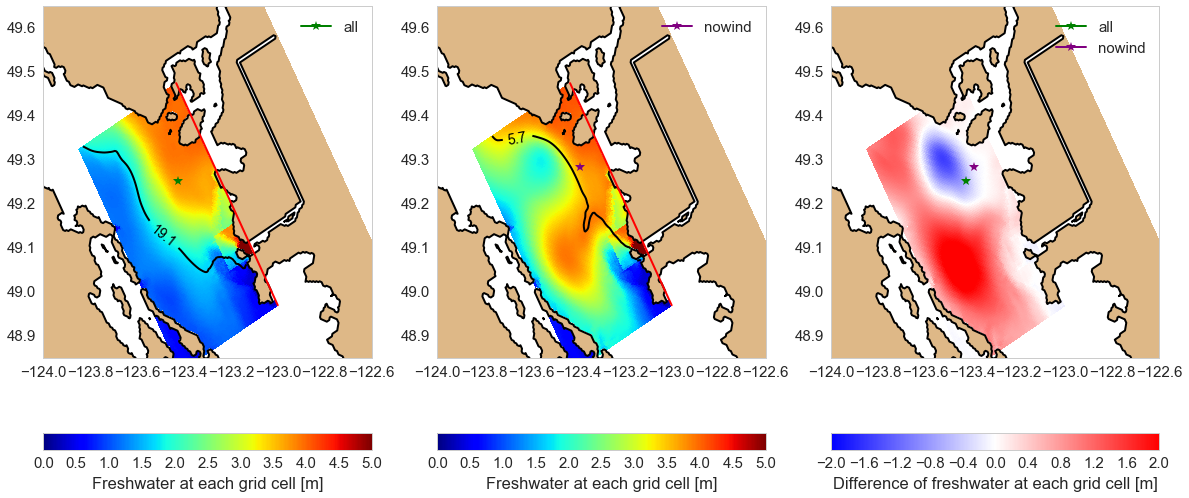

In [15]:
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
## check the first day of weird moderate SE wind May
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,360,384,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE )

{'all': 86.689818022942958, 'nowind': 90.556182615451249} {'all': 52.90504625536488, 'nowind': 59.024372588675725}


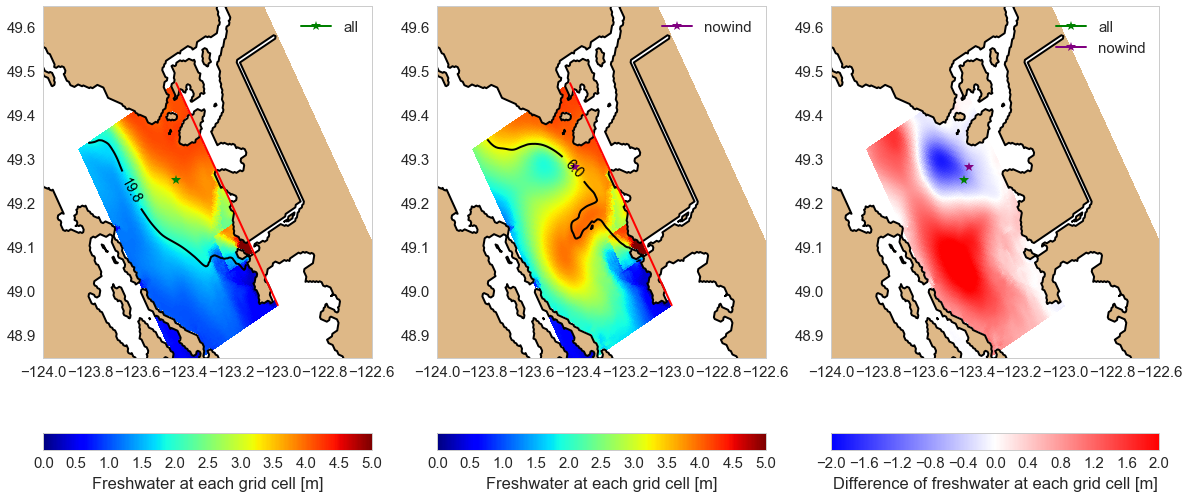

In [16]:
## check the second day
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,384,408,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE )

{'all': 84.841611420889834, 'nowind': 90.366144141621859} {'all': 49.648779613365008, 'nowind': 55.451622404818295}


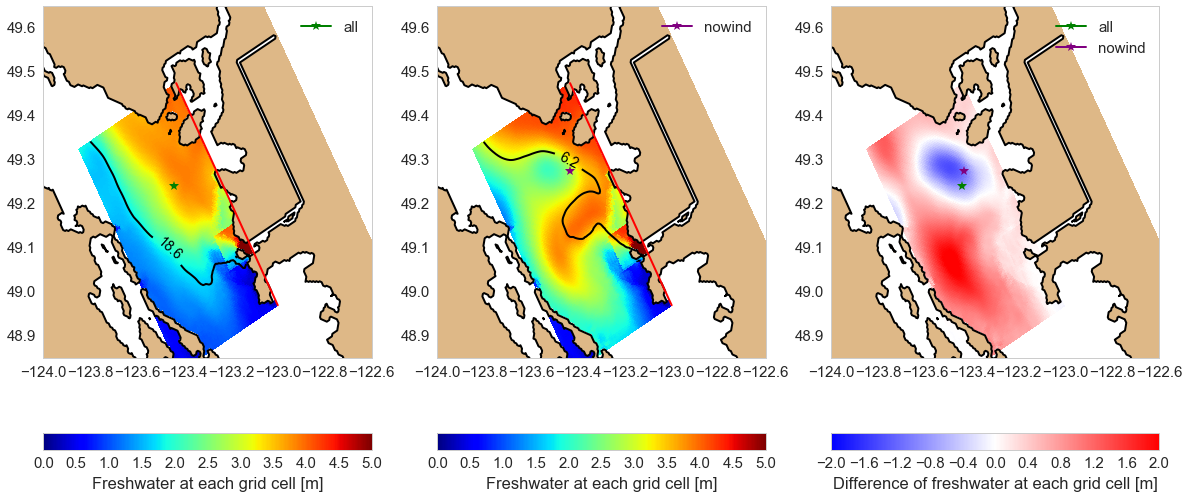

In [17]:
## check the third day
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,408,432,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE )

{'all': 77.82780912257661, 'nowind': 86.012450134115724} {'all': 44.02368831378714, 'nowind': 48.25472702570633}


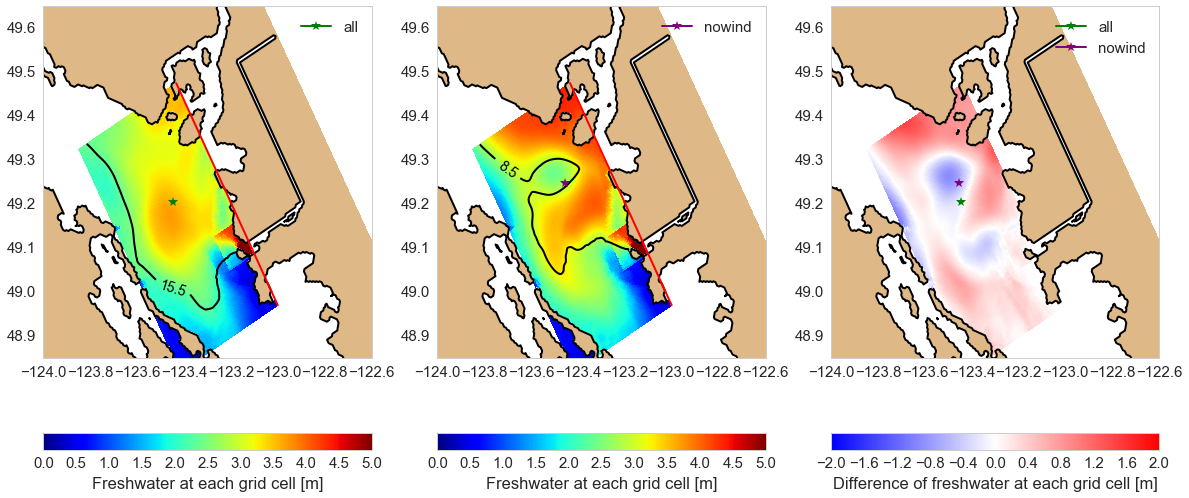

In [18]:
## check the last day
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,432,456,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE )

* This mass centre location method loses its validaty during May (high river flow) since the weight of Squamish river counts more in determine the centre location than the wind.

{'all': 79.190114257957291, 'nowind': 70.873069201804768} {'all': 43.522633774628034, 'nowind': 39.811709605940138}


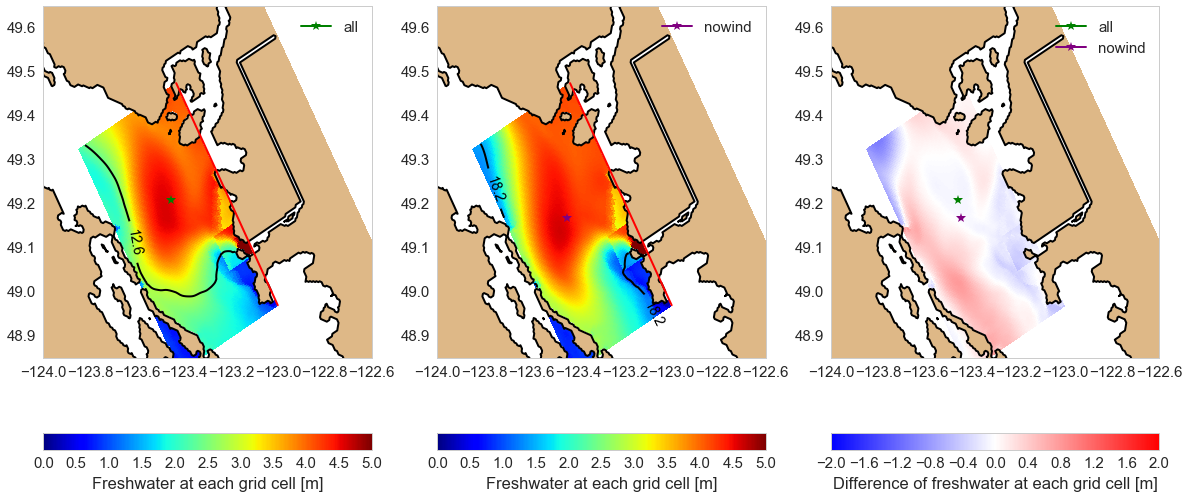

In [19]:
## Another moderate wind period from N in May
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,648,695,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE)

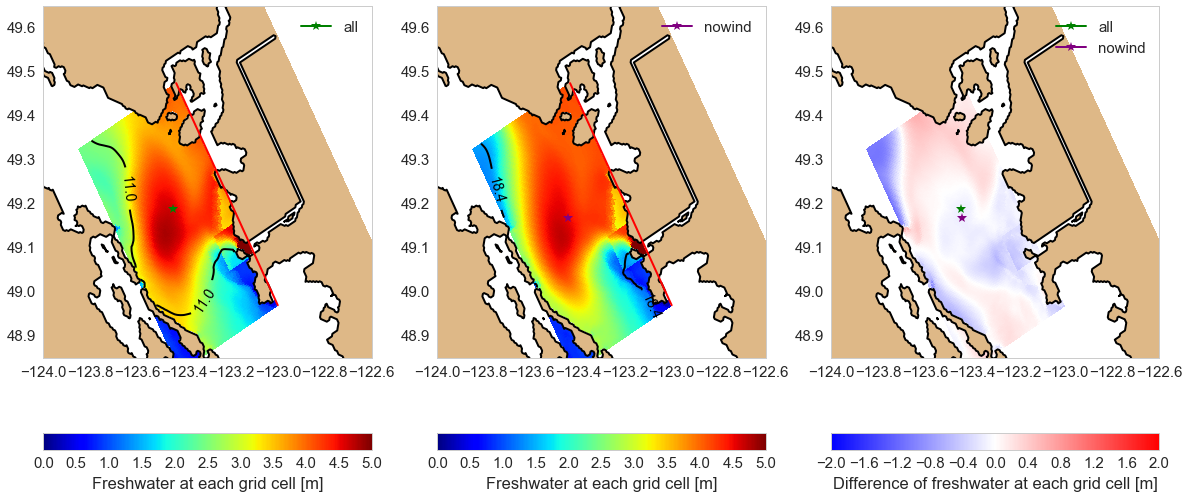

In [37]:
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,672,695,10,0,yslices,xslices,['all','nowind'])

{'all': 77.548232739396028, 'nowind': 74.773798036424097} {'all': 48.415075274690047, 'nowind': 51.902653828781396}


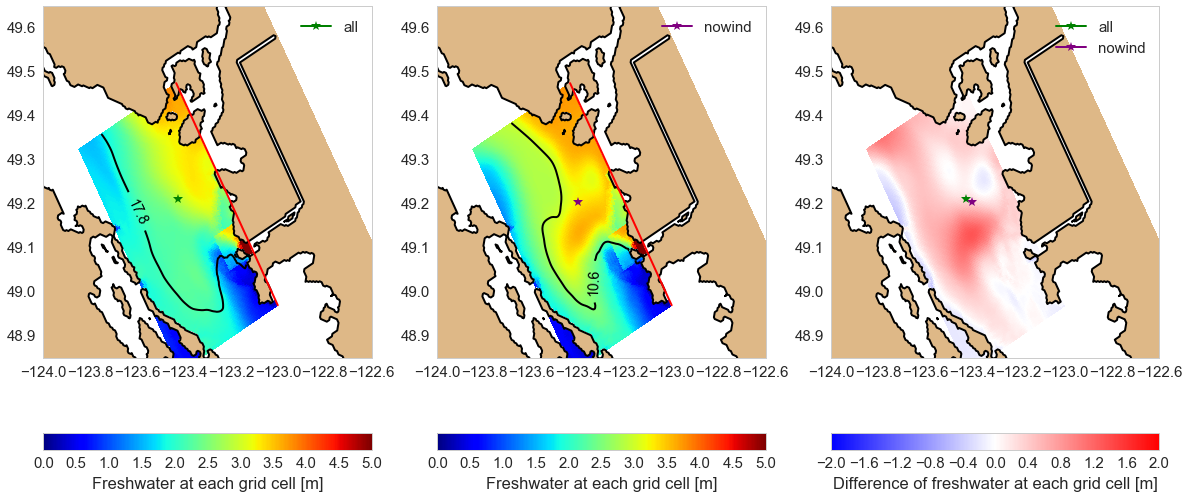

In [20]:
## Another moderate wind period from N in May
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,144,216,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_windSE,ipos_may_windSE )

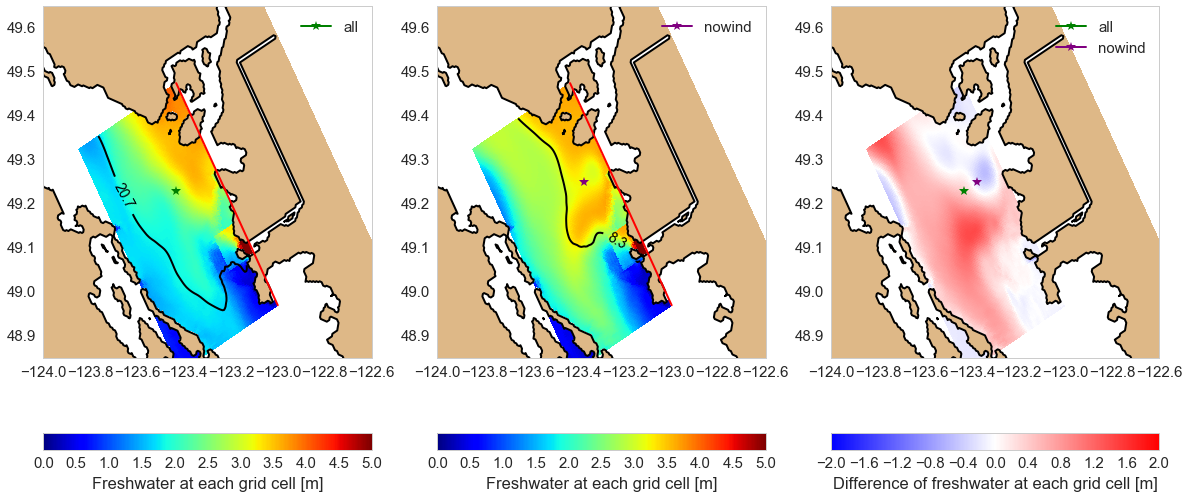

In [26]:
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,144,168,10,0,yslices,xslices,['all','nowind'])

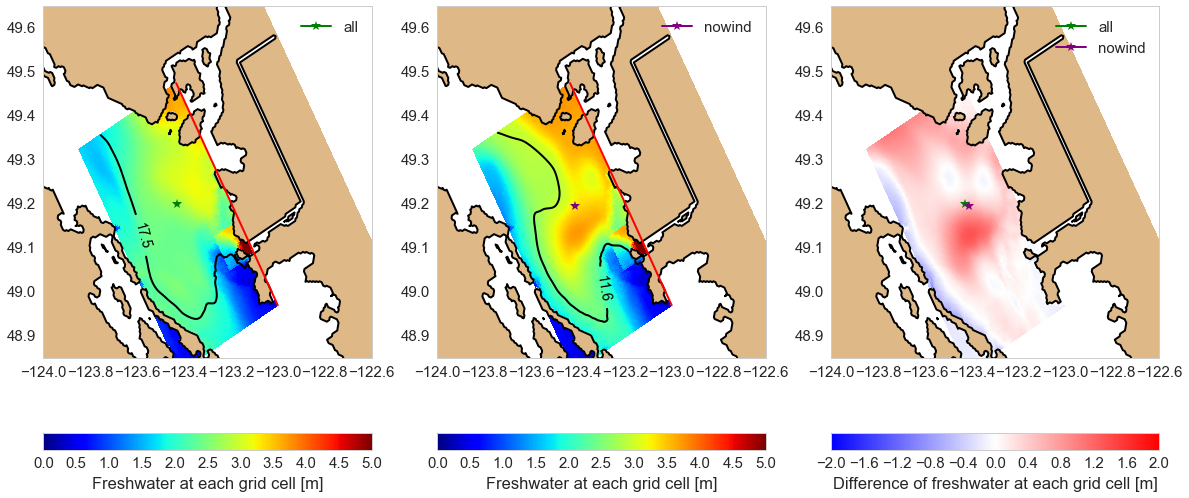

In [29]:
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,168,192,10,0,yslices,xslices,['all','nowind'])

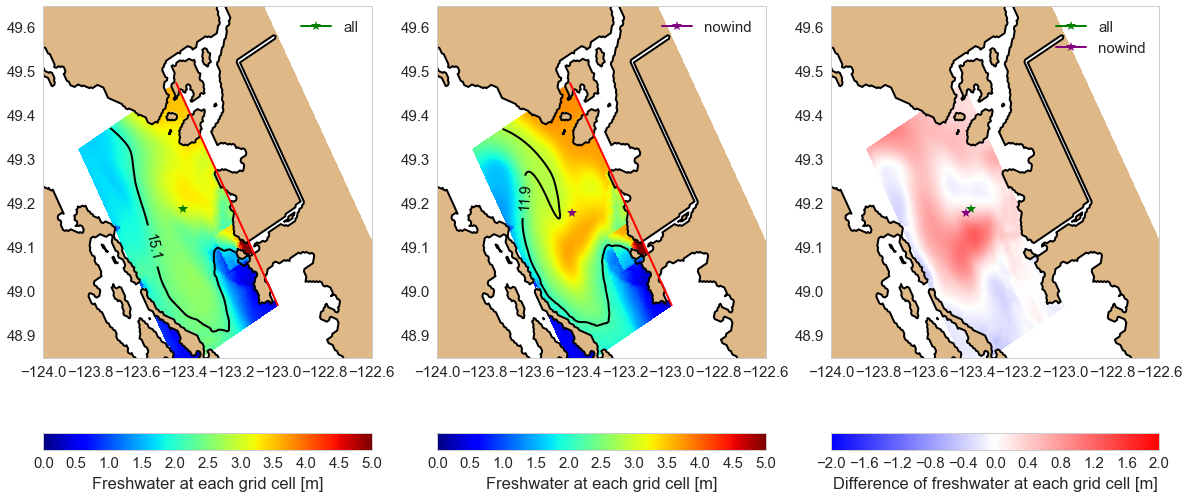

In [30]:
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,192,216,10,0,yslices,xslices,['all','nowind'])

* From their daily averaged location, it appears freshwater blob moves southward with wind blowing to south, but without wind, the southward extension of freshwater blob is growing more rapidly. And this extension may be caused by gravity force. So, i think this method still not work very efficiently to look at the center changed by wind during high river flow.

{'all': 84.51954538776296, 'nowind': 81.086855459608785} {'all': 56.824522911516681, 'nowind': 48.17354314762045}


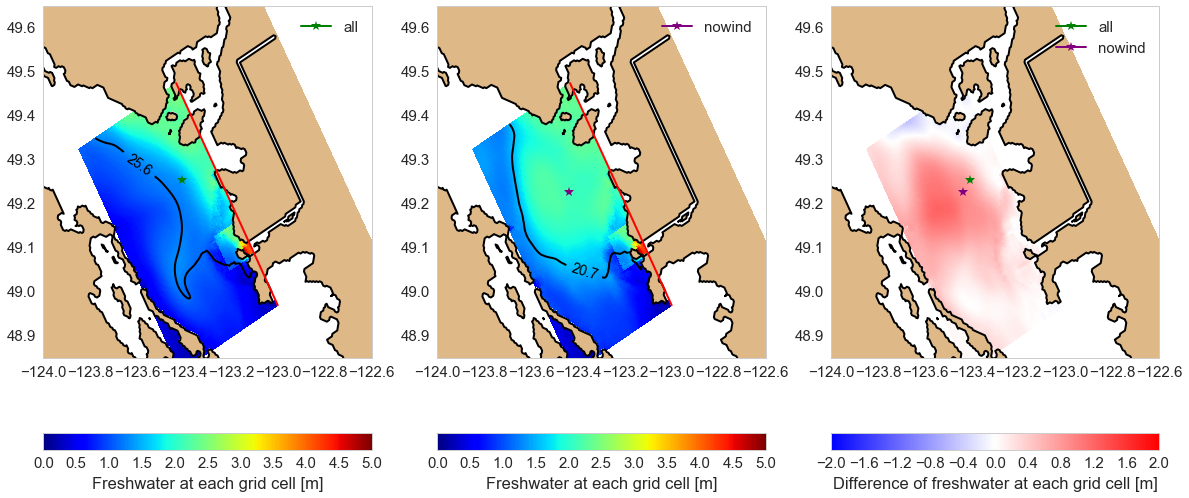

In [21]:
## wind from south blow to north, high Jan
jpos_jan_windHi,ipos_jan_windHi = plot_plume_position(janall_T,jannowind_T,624,671,10,0,yslices,xslices,['all','nowind'])
print(jpos_jan_windHi,ipos_jan_windHi)

{'all': 89.79189464124164, 'nowind': 83.016762391843585} {'all': 55.263926174744221, 'nowind': 52.237645577541549}


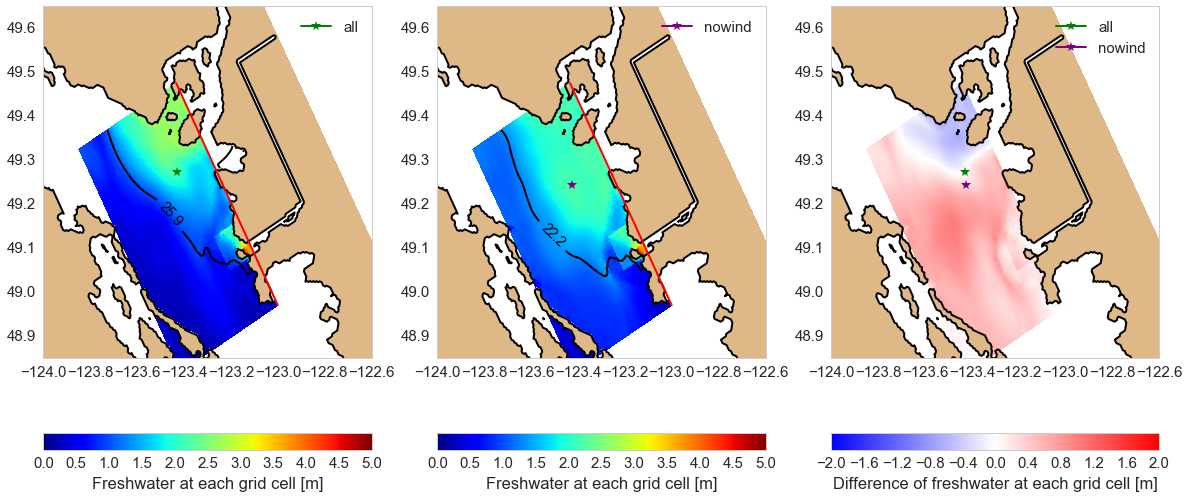

In [22]:
jpos_jan_windHii,ipos_jan_windHii = plot_plume_position(janall_T,jannowind_T,480,503,10,0,yslices,xslices,['all','nowind'])
print(jpos_jan_windHii,ipos_jan_windHii)

In [23]:
geo_tools.haversine(X[380+73, 240+42],Y[380+73, 240+42],X[380+81, 240+47],Y[380+81, 240+47])

4.5337346332038715

{'all': 86.42781647569376, 'nowind': 84.945773554321406} {'all': 63.090487019572556, 'nowind': 52.358197021180999}


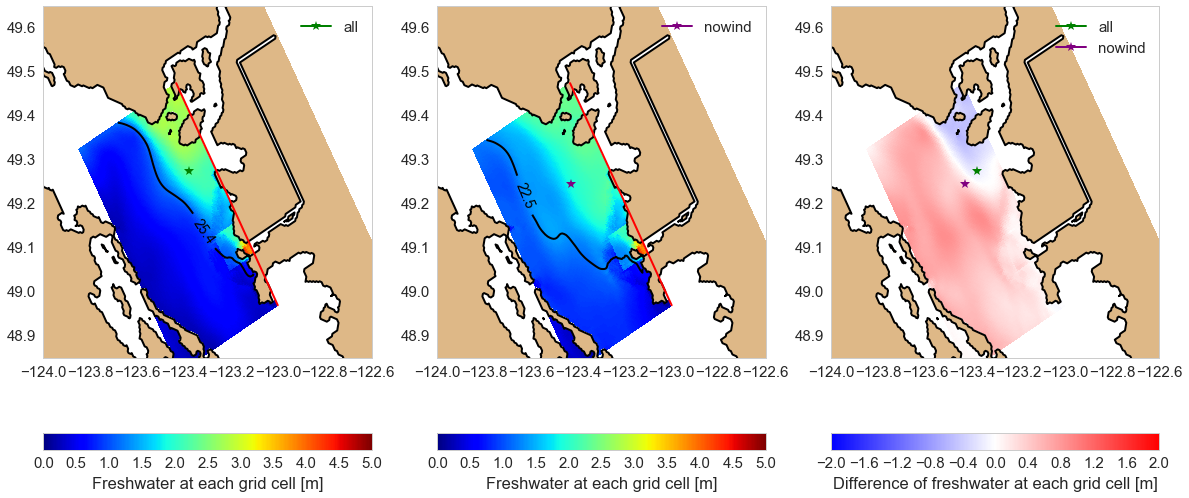

In [24]:
## wind from south blow to north, moderate Jan
jpos_jan_windMo,ipos_jan_windMo = plot_plume_position(janall_T,jannowind_T,384,455,10,0,yslices,xslices,['all','nowind'])
print(jpos_jan_windMo,ipos_jan_windMo)

{'all': 57.509850248513608, 'nowind': 70.499508133973478} {'all': 42.679900209106414, 'nowind': 55.226452155253824}


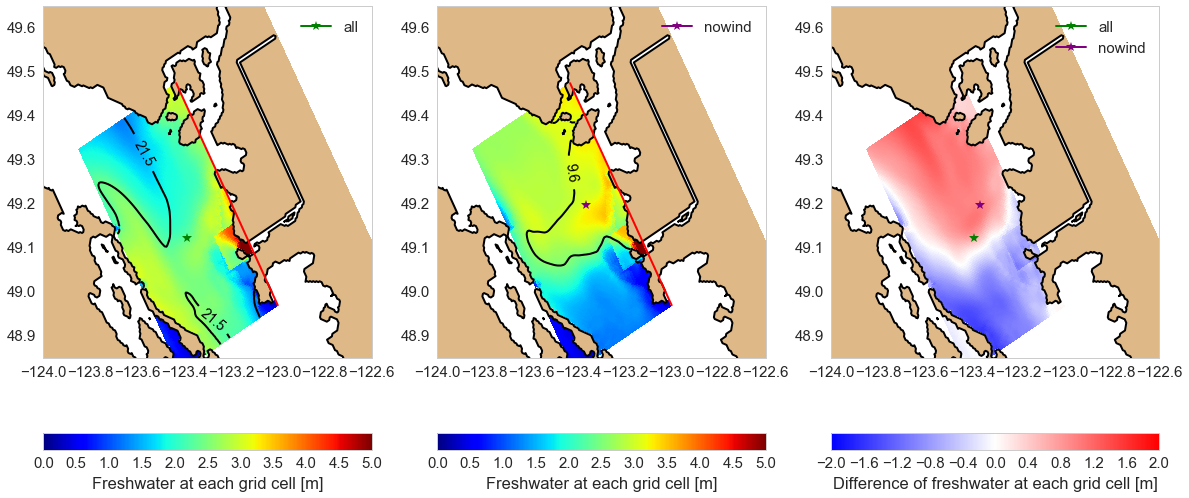

In [25]:
## wind from north blow to south
## less freshwater at south without wind.
jpos_may_wind,ipos_may_wind = plot_plume_position(mayall_T,maynowind_T,24,71,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_wind,ipos_may_wind )

# Weak wind

{'all': 67.389188647675184, 'nowind': 65.508792753448148} {'all': 44.508180002871022, 'nowind': 48.956797236592308}


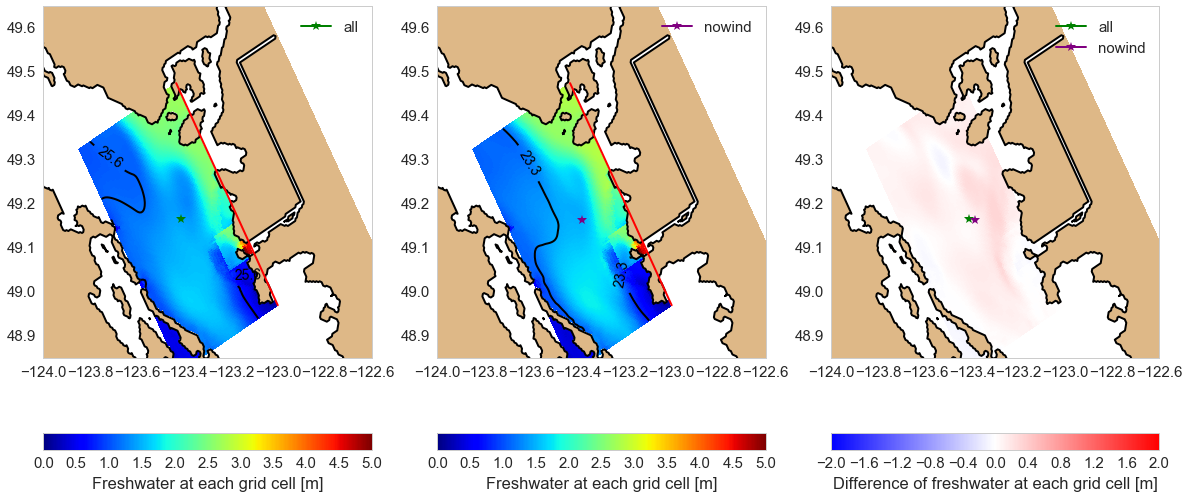

In [26]:
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
jpos_oct_Weak,ipos_oct_Weak = plot_plume_position(octall_T,octnowind_T,48,143,10,0,yslices,xslices,['all','nowind'])
print(jpos_oct_Weak,ipos_oct_Weak)

{'all': 73.23793141122448, 'nowind': 72.57448314719683} {'all': 48.968299246001898, 'nowind': 46.441835175608624}


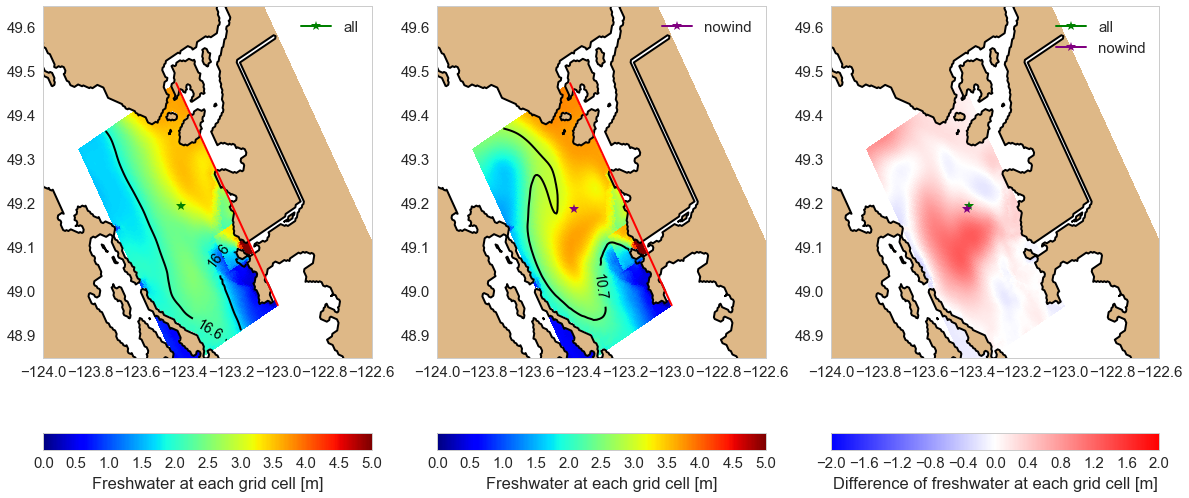

In [27]:
jpos_may_Weak,ipos_may_Weak = plot_plume_position(mayall_T,maynowind_T,192,263,10,0,yslices,xslices,['all','nowind'])
print(jpos_may_Weak,ipos_may_Weak )

{'all': 70.453387324444748, 'nowind': 69.438341216441813} {'all': 51.02960618795705, 'nowind': 51.312202624786785}


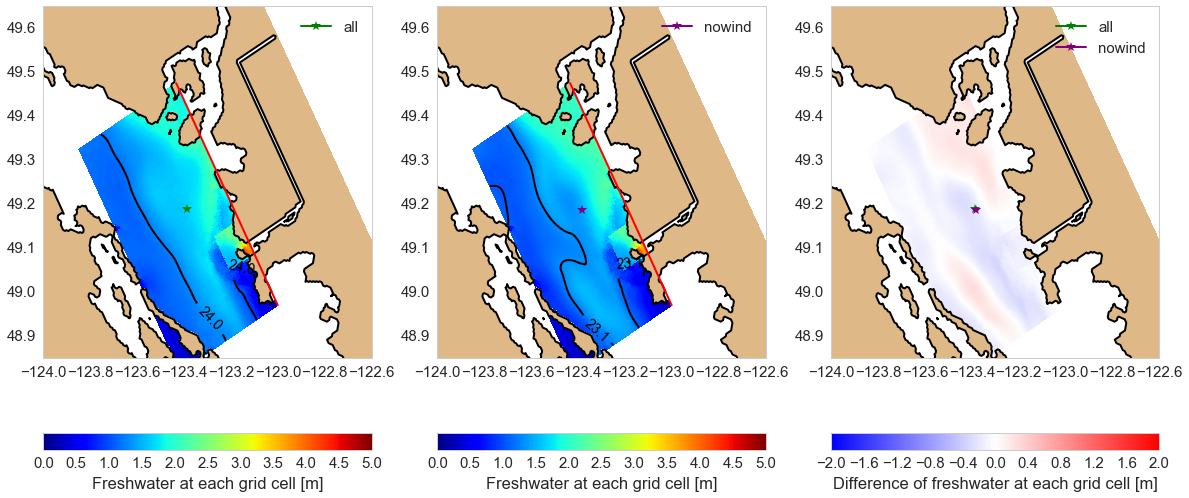

In [28]:
jpos_jan_Weak,ipos_jan_Weak = plot_plume_position(janall_T,jannowind_T,168,239,10,0,yslices,xslices,['all','nowind'])
print(jpos_jan_Weak,ipos_jan_Weak)

In [22]:
geo_tools.haversine(X[380+68,240+42],Y[380+68,240+42],X[380+69,240+42],Y[380+69,240+42])

0.49912528902679559

# River effects

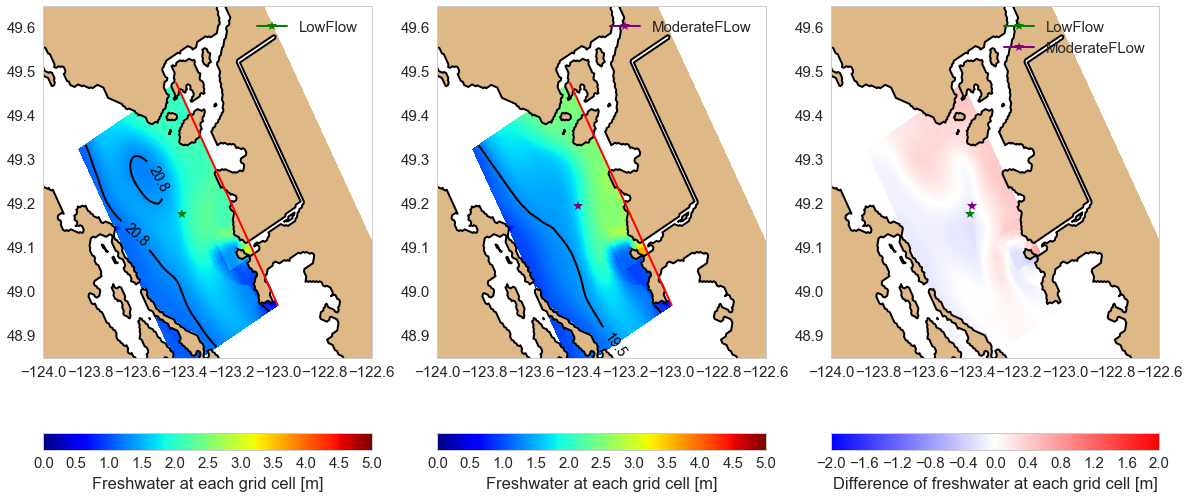

In [16]:
## low and intermediate
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
jpos_LoIn,ipos_LoIn = plot_plume_position(janriver_T,octriver_T,0,743,10,0,yslices,xslices,['LowFlow','ModerateFLow'])

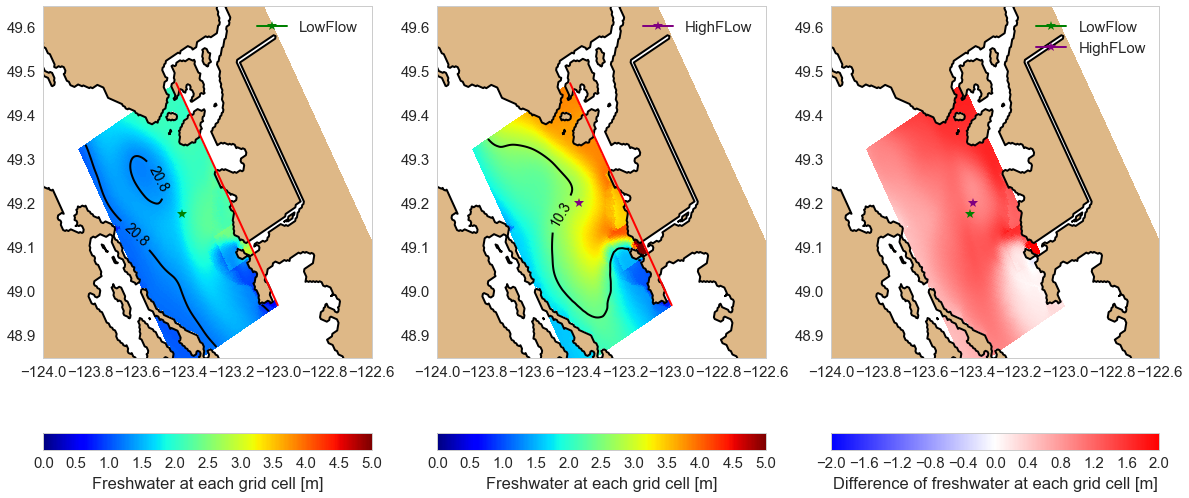

In [17]:
## low and high
jpos_LoHi,ipos_LoHi = plot_plume_position(janriver_T,mayriver_T,0,743,10,0,yslices,xslices,['LowFlow','HighFLow'])

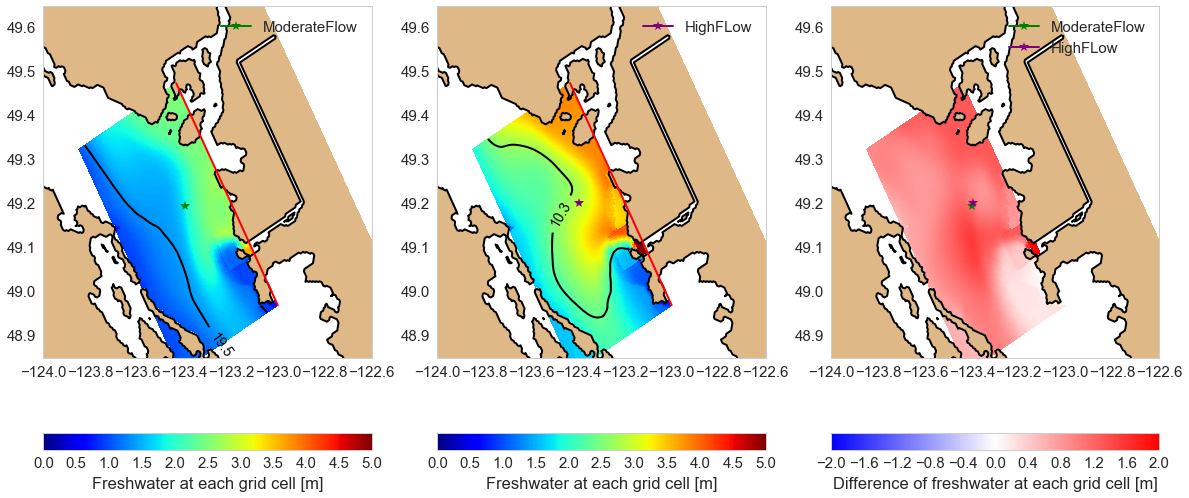

In [18]:
## intermeidate and high
jpos_InHi,ipos_InHi = plot_plume_position(octriver_T,mayriver_T,0,743,10,0,yslices,xslices,['ModerateFlow','HighFLow'])

In [20]:
print(jpos_LoHi,ipos_LoHi)
print(jpos_InHi,ipos_InHi)

{'HighFLow': 73.52317867718051, 'LowFlow': 69.07166337454268} {'HighFLow': 51.711376023210796, 'LowFlow': 46.597290653732614}
{'ModerateFlow': 72.108075688802558, 'HighFLow': 73.52317867718051} {'ModerateFlow': 50.086890633967833, 'HighFLow': 51.711376023210796}


(48.85, 49.65)

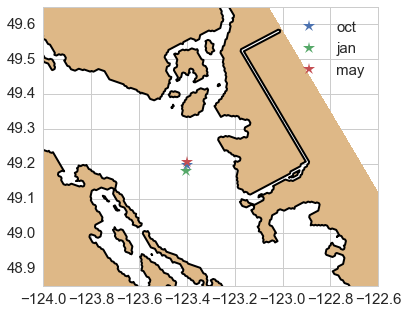

In [21]:
## plume location under weak wind for different month
fig, ax = plt.subplots(1,1,figsize = (6,5))
ax.plot(X[380+72,240+50],Y[380+72,240+50],'*',markersize = 12,label = 'oct')
ax.plot(X[380+69,240+47],Y[380+69,240+47],'*',markersize = 12,label = 'jan')
ax.plot(X[380+74,240+51],Y[380+74,240+51],'*',markersize = 12,label = 'may')
ax.legend(loc = 'best')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_xlim([-124.,-122.6])
ax.set_ylim([48.85,49.65])

* This indicates that freshwater amount does not affect the plume position much, but did move the center location northward with increasing discharge.